# ADVI - Automatic Differentiation VI

When the problem at hand is not from the exponential family (or a conjugate family) (SVI from [Stochastic Variational Inference, Hoffman 2013](https://www.jmlr.org/papers/volume14/hoffman13a/hoffman13a.pdf)) we have to rely on stochastic approaches.

[ADVI](https://arxiv.org/abs/1603.00788) is one such approach.

I will use the mean field variational families (Gaussian - Is this assumed by mean field?)

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

tfd = tfp.distributions


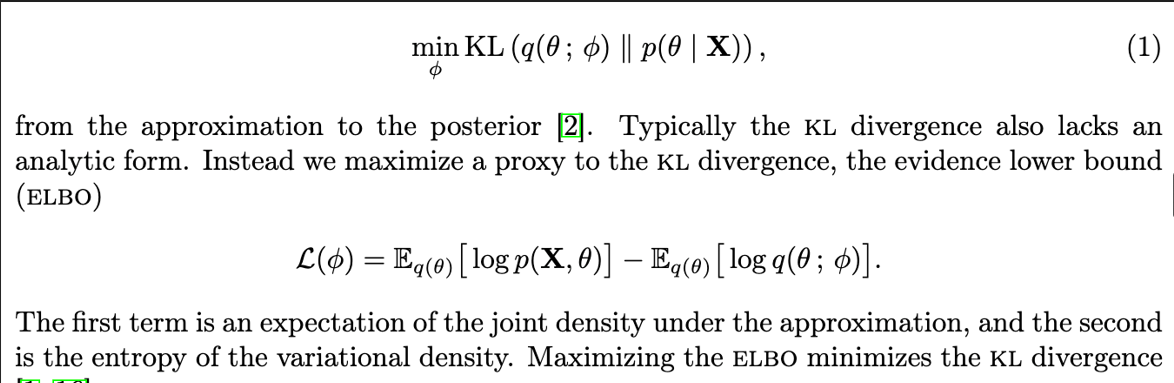

"without priors its just a flat prior and that’s alright?"

In [3]:
def plot_dist(dist, ax, n_samples=None):

    if n_samples:
        x1,x2 = zip(*dist.sample(n_samples))
        ax.scatter(x1,x2)

    x1_mesh, x2_mesh = np.mgrid[-3:5:.01, -3:5:.01]
    pos = np.dstack((x1_mesh, x2_mesh))
    pdf = dist.prob(pos)

    ax.contour(x1_mesh, x2_mesh, pdf, cmap='inferno')#, cmap='viridis'

# 1. Surrogate of the mean 

In [6]:
# Target/True
true_mean = [0.3, 0.7]
true_cov = [[0.8, 0.3],
            [0.3, 1.8]]

target_distribution = tfd.MultivariateNormalFullCovariance(
    loc=true_mean,
    covariance_matrix=true_cov
)

def get_batch(n_samples=100):
    # placeholder batcher and dataloader
    return target_distribution.sample(n_samples)

## --- ADVI -----

# mean-field Gaussian distribution
q_mu = tf.Variable([0.0, 1.0], dtype=tf.float32, name='q_mu')
q_sigma = tfp.util.TransformedVariable([1.0,2.0], name='q_sigma', bijector=tfp.bijectors.Softplus())
q_distribution = tfd.MultivariateNormalDiag(loc=q_mu, scale_diag=q_sigma)

# Setup
n_steps = 1000
learning_rate = 0.1
reparam = True

optimizer = tf.keras.optimizers.Adam(learning_rate)
#optimizer.build(q_distribution.trainable_variables)
batch = get_batch(n_samples=100)
for step in range(n_steps):
    with tf.GradientTape() as tape:

        if reparam: # Very noticeable difference in performance.
            epsilon = tf.random.normal(shape=batch.shape, mean=0, stddev=1)
            batch = q_mu + epsilon * q_sigma
    
        kl_divergence = tfd.kl_divergence(q_distribution, target_distribution)#target_distribution
        elbo_loss = -tf.reduce_mean(q_distribution.log_prob(batch)) + kl_divergence
       

    # compute gradients and update the parameters
    gradients = tape.gradient(elbo_loss, q_distribution.trainable_variables)#[q_mu, q_sigma])
    optimizer.apply_gradients(zip(gradients, q_distribution.trainable_variables))

    if step % 100 == 0:
        print(f'step {step}, ELBO Loss: {elbo_loss.numpy()}')

print('Optimized q_mu:', q_mu.numpy())
print('Optimized q_sigma:', q_sigma.numpy())

step 0, ELBO Loss: 3.896972417831421
step 100, ELBO Loss: 2.102184534072876
step 200, ELBO Loss: 1.931349277496338
step 300, ELBO Loss: 1.9393463134765625
step 400, ELBO Loss: 2.108370065689087
step 500, ELBO Loss: 1.8453083038330078
step 600, ELBO Loss: 2.0187830924987793
step 700, ELBO Loss: 2.024867057800293
step 800, ELBO Loss: 2.0822553634643555
step 900, ELBO Loss: 2.182711601257324
Optimized q_mu: [0.3 0.7]
Optimized q_sigma: [0.01689796 0.0314867 ]


Text(0.5, 1.0, 'Surrogate')

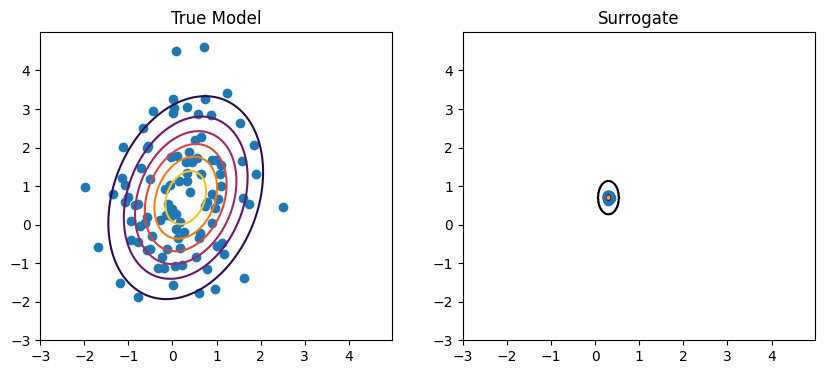

In [7]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs = axs.flat

plot_dist(target_distribution, axs[0], 100)
axs[0].set_title('True Model')

plot_dist(q_distribution, axs[1], 100)
axs[1].set_title('Surrogate')

### In this case the std shown in the surrogate figure represents the uncertainty of the parameter. Not of the data. To achieve this we must model the covariance matrix aswell.

# 2. Full Model - A brutal approach

The covariance matrix has some nessecary conditions.
- Symmetric
- Positive diagonal

This implies that we to reinforce these conditions when we sample from the surrogate models that represents the covariance matrix.
In this example this is done in quite a brute force approach, where we enfore the conditions using SoftPlus(). It works well but I'm sure there are cleaner approaches.
(Todo: investigate Wihart+Cholesky factorization. lognorm? )

Q: Why are we not using the reparametrization trick?

In [20]:
# Target/True
true_mean = [0.3, 0.7]
true_cov = [[0.8, 0.3],
            [0.3, 1.8]]

target_distribution = tfd.MultivariateNormalFullCovariance(
    loc=true_mean,
    covariance_matrix=true_cov
)

def get_batch(n_samples=100):
    # placeholder batcher and dataloader
    return target_distribution.sample(n_samples)



## --- ADVI -----

# mean-field Gaussian distribution

# Surrogate for the mean
q_mu = tf.Variable([0.0, 1.0], dtype=tf.float32, name='q_mu')
q_sigma = tfp.util.TransformedVariable([1.0,2.0], name='q_sigma', bijector=tfp.bijectors.Softplus())
q_distribution = tfd.MultivariateNormalDiag(loc=q_mu, scale_diag=q_sigma)


# Surrogate for the cov
# Note that it is not nessecary for us to assume the data is independent. The mean field assumption assumes only that the parameters are.
q_cov_mu = tf.Variable([1.0, 1.0, 0.1],
    dtype=tf.float32,
    name='q_cov_mu'
)
q_cov_sigma = tfp.util.TransformedVariable([0.1, 0.1, 0.01], name='q_cov_sigma', bijector=tfp.bijectors.Softplus())
q_cov_distribution = tfd.MultivariateNormalDiag(loc=q_cov_mu, scale_diag=q_cov_sigma)


# Setup
n_steps = 3000
learning_rate = 0.001
reparam = False 

optimizer = tf.keras.optimizers.Adam(learning_rate)

infinite_dataset = True # to check whter the Approximate model converges to the true

X = get_batch(n_samples=500)

for step in range(n_steps):
    if infinite_dataset:
        X = get_batch(n_samples=100)
    with tf.GradientTape() as tape:
        
        theta_means = q_distribution.sample() #one para value for the posterior
        theta_cov_diag = q_cov_distribution.sample()
        theta_cov_diag = [tfp.bijectors.Softplus()(i) for i in theta_cov_diag]
        #print('theta_cov_diag', theta_cov_diag)
        cov_matrix = [[theta_cov_diag[0], theta_cov_diag[2]], [theta_cov_diag[2], theta_cov_diag[1]]]
        #model = tfd.MultivariateNormalDiag(loc=theta_means, scale_diag=theta_cov_diag)
        model = tfd.MultivariateNormalFullCovariance(loc=theta_means, covariance_matrix=cov_matrix)


        #if reparam: # Very noticeable difference in performance.
        #    epsilon = tf.random.normal(shape=X.shape, mean=0, stddev=1)
        #    batch = q_mu + epsilon * q_sigma
        
        entropy_variational_density = q_distribution.entropy() + q_cov_distribution.entropy()
        expectation_joint_density = tf.reduce_sum(model.log_prob(X))#q_distribution.log_prob(batch)) 
        elbo = expectation_joint_density - entropy_variational_density
        elbo_loss = -elbo
     

    # compute gradients and update the parameters
    gradients = tape.gradient(elbo_loss, q_distribution.trainable_variables + q_cov_distribution.trainable_variables)#[q_mu, q_sigma])
    optimizer.apply_gradients(zip(gradients, q_distribution.trainable_variables + q_cov_distribution.trainable_variables))
    
    if step % 100 == 0:
        print(f'step {step}, ELBO Loss: {elbo_loss.numpy()}', 'q_mu:',  q_mu.numpy() , 'q_sigma:', q_sigma.numpy())

print('Optimized q_mu:', q_mu.numpy())
theta_means = q_distribution.sample() #one para value for the posterior
theta_cov_diag = q_cov_distribution.sample()
theta_cov_diag = [tfp.bijectors.Softplus()(i) for i in theta_cov_diag]
print('Optimized Cov Matrix:', theta_cov_diag)
#print('Optimized q_sigma:', q_sigma.numpy()).

step 0, ELBO Loss: 386.6831359863281 q_mu: [0.00099999 0.999     ] q_sigma: [0.999368  1.9991354]
step 100, ELBO Loss: 2122.281982421875 q_mu: [0.02977723 0.97556865] q_sigma: [0.96332973 1.9473047 ]
step 200, ELBO Loss: 385.3368835449219 q_mu: [0.06306607 0.95116514] q_sigma: [0.9418864 1.8942224]
step 300, ELBO Loss: 408.8270263671875 q_mu: [0.08898084 0.9316096 ] q_sigma: [0.9155401 1.8507676]
step 400, ELBO Loss: 390.557373046875 q_mu: [0.10412285 0.91427463] q_sigma: [0.89448345 1.8109596 ]
step 500, ELBO Loss: 379.69073486328125 q_mu: [0.11727312 0.9019114 ] q_sigma: [0.8730508 1.7830267]
step 600, ELBO Loss: 358.0060119628906 q_mu: [0.12944531 0.896591  ] q_sigma: [0.8511962 1.7521276]
step 700, ELBO Loss: 408.94830322265625 q_mu: [0.15395775 0.87797374] q_sigma: [0.8304975 1.7235534]
step 800, ELBO Loss: 367.9460144042969 q_mu: [0.1664301 0.869902 ] q_sigma: [0.8082244 1.6878321]
step 900, ELBO Loss: 433.3592834472656 q_mu: [0.1791319 0.8689269] q_sigma: [0.78656405 1.6556668 ]

Text(0.5, 1.0, 'Approximate Model')

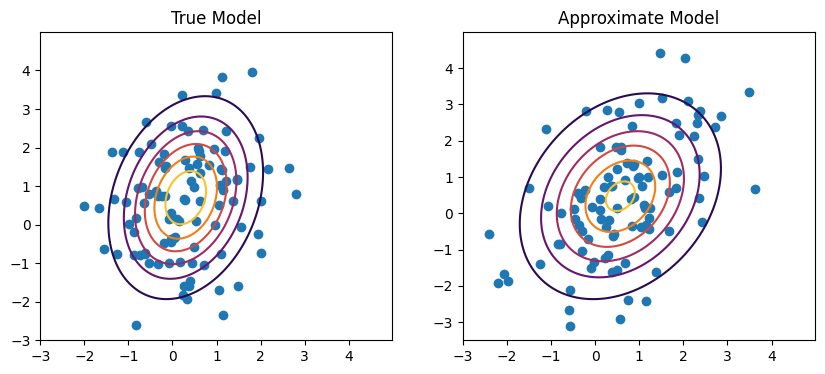

In [16]:
# Create True Model
# 2D Gaussian

def plot_dist(dist, ax, n_samples=None):

    if n_samples:
        x1,x2 = zip(*dist.sample(n_samples))
        ax.scatter(x1,x2)

    x1_mesh, x2_mesh = np.mgrid[-3:5:.01, -3:5:.01]
    pos = np.dstack((x1_mesh, x2_mesh))
    pdf = dist.prob(pos)

    ax.contour(x1_mesh, x2_mesh, pdf, cmap='inferno')#, cmap='viridis'


fig, axs = plt.subplots(1,2, figsize=(10,4))
axs = axs.flat

plot_dist(target_distribution, axs[0], 100)
axs[0].set_title('True Model')

theta_cov_diag = q_cov_distribution.sample()
theta_cov_diag = [tfp.bijectors.Softplus()(i) for i in theta_cov_diag]
cov_matrix = [[theta_cov_diag[0], theta_cov_diag[2]], [theta_cov_diag[2], theta_cov_diag[1]]]
model = tfd.MultivariateNormalFullCovariance(loc=theta_means, covariance_matrix=cov_matrix)

plot_dist(model, axs[1], 100)
axs[1].set_title('Approximate Model')



In [17]:
cov_matrix

[ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=1.422478>, <tf.Tensor: shape=(), dtype=float32, numpy=0.47721207>]),
 ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=0.47721207>, <tf.Tensor: shape=(), dtype=float32, numpy=2.198277>])]

In [11]:
gradients

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([108.489204, -91.41028 ], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([19.014112, 17.64845 ], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([57.700672 ,  1.4895732,  2.9330604], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.0134718 , 1.0133588 , 0.99040866], dtype=float32)>)

In [12]:
theta_cov_diag

[<tf.Tensor: shape=(), dtype=float32, numpy=1.4077461>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.1154323>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.4742592>]

# Some unfinished ideas

In [24]:
"""
If the target distribution is unknown, you cannot directly compute the log probability. 
    In practice, you usually have access to samples from the target distribution and an 
    unnormalized log probability function, also known as the log joint probability,
    which includes the data likelihood and the prior probability.
"""

def log_joint_probability(theta, X):
    # The prior probability for theta
    prior = tfd.MultivariateNormalDiag(loc=[0.0, 0.0], scale_diag=[1.0, 1.0])
    log_prior = prior.log_prob(theta)

    # The likelihood of the data given theta
    likelihood = tfd.MultivariateNormalFullCovariance(loc=theta, covariance_matrix=true_cov)
    log_likelihood = tf.reduce_sum(likelihood.log_prob(X), axis=0)

    # The log joint probability
    return log_prior + log_likelihood

In [25]:
# Since the target_distribution is unknown we need a prior??
prior_mean = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.])
prior_cov = tfd.WishartTriL(df=3, scale_tril=tf.linalg.cholesky([[1., 0.], [0., 1.]])) # This is a common prior for covariance


prior_mean = [0.0, 1.0]
prior_cov = [[1.0, 0.0],
            [0.0, 1.0]]
prior_dist = tfd.MultivariateNormalFullCovariance(
    loc=prior_mean,
    covariance_matrix=prior_cov
)
